### Training RF-models

Linn Alexandra Emhjellen, 2021. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

In [2]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.metrics import recall_score,roc_curve,auc
from pandas.plotting import scatter_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
import seaborn as sns

### Loading calibration set

In [3]:
train_X = pd.read_excel('ML_training_features.xlsx')
train_y = pd.read_excel('ML_training_target.xlsx')

### Loading validation set

In [4]:
validation_X = pd.read_excel('ML_validation_features.xlsx')
validation_y = pd.read_excel('ML_validation_target.xlsx')

#### y-label

In [5]:
validation_y = validation_y['ReleaseArea']
train_y = train_y['ReleaseArea']

#### The optimized hyperparameters from RandomSearch with cross-validation

In [6]:
best_params_RF = pd.read_excel('RF_best_params_RandomSearch.xlsx')
best_params_RF = best_params_RF.drop(columns = 'Unnamed: 0')

best_param_grid = best_params_RF.to_dict(orient = 'records')

#### Defining feature combinations

In [7]:

p1 = ['Slope']

p2 = ['Slope','Elevation']

p3 = ['Slope','North','East','North East','North West','South','South East','South West','West']

p4 = ['Slope','Elevation','Plan_curv','Profile_curv','TRI','Distance_to_roads']

p5 = ['Slope','Elevation','Plan_curv','Profile_curv','TRI','Flow_dir','Flow_acc','Distance_to_roads']

p6 = ['Slope','Elevation','Plan_curv','Profile_curv','TRI']

p7 = ['Elevation','North','East','North East','North West','South','South East','South West','West','Plan_curv','Profile_curv','TRI','Flow_dir','Flow_acc','Distance_to_roads']

p8 = ['Slope','Elevation','North','East','North East','North West','South','South East','South West','West','Plan_curv','Profile_curv','TRI','Flow_dir','Flow_acc','Distance_to_roads',
      'Granite','Granodiorite','Tonalite','Trondhjemite','Syenite','Monzonite','Monzodiorite','Quartz diorite','Diorite','Gabbro','Norite','Peridotite','Pyroksenite','Charnockite','Mangerite','Anorthosite','Mafic dyke (Diabase, Dolerite)','Pegmatite/aplite','Felsic volcanic rock','Rhyolite','Dacite','Intermediate volcanic rock','Andesite','Mafic volcanic rock','Basalt',
                  'Pyroclastic rock','Volcanic breccia','Siltstone','Sandstone','Greywacke','Arkose','Konglomerate','Sedimentary breccia','Limestone','Tuffite','Shale','Phyllite','Mica schist','Garnet mica schist','Calcareous phyllite','Calcareous mica schist','Amphibole schist','Graphitic schist','Calcite marble',
                 'Metasandstone','Metagreywacke','Meta-arkose','Quartzite','Quartz schist','Mica gneiss','Calc-silicate rock','Amphibole gneiss','Granitic gneiss','Granodioritic gneiss','Tonalitic gneiss','Quartz dioritic gneiss','Monzonitic gneiss','Dioritic gneis','Orthopyroxene gneiss','Migmatite','Augengneiss',
                    'Banded gneiss','Greenschist','Greenstone','Amphibolite','Metagabbro','Eclogite','Serpentinite','Mylonite/Phyllonite','Cataclasite']

feature_combinations = [p1,p2,p3,p4,p5,p6,p7,p8]

### Training of models

In [9]:
clf_models = []
pred_release_training_RF = []
pred_release_testing_RF = []
pred_release_prob_RF = []
accuracy_scores_training = []
accuracy_scores_test = []
confusion_matrixes_training = []
confusion_matrixes_test = []
feature_importances = []
roc_auc_scores = []

f1_scores = []
ROC_curves = []
CV_scores = []
R2_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

n = 0
for i in feature_combinations:
    
    X_train = train_X[i]
    X_test = validation_X[i]

    AUTO_SCALING = True
    if AUTO_SCALING:
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_training = scaler.transform(X_train)
        X_testing = scaler.transform(X_test)
       
    
    clf_RF = RandomForestClassifier(n_jobs=-1, n_estimators = best_params_RF.iloc[n][0], min_samples_leaf = best_params_RF.iloc[n][1],max_depth = best_params_RF.iloc[n][2],  random_state=0, oob_score=True,)
    clf_RF.fit(X_training, train_y)
    clf_models.append(clf_RF)
    
    pred_release_at_training_RF = clf_RF.predict(X_training)
    pred_release_training_RF.append(pred_release_at_training_RF)
    
    pred_release_at_validation_RF = clf_RF.predict(X_testing)
    pred_release_testing_RF.append(pred_release_at_validation_RF)
    
    pred_prob_RF = clf_RF.predict_proba(X_testing)
    pred_release_prob_RF.append(pred_prob_RF)
    
    a_s = accuracy_score(train_y, pred_release_at_training_RF)
    accuracy_scores_training.append(a_s)
    
    c_m = confusion_matrix(train_y,pred_release_at_training_RF)
    confusion_matrixes_training.append(c_m)
    
    a_s1 = accuracy_score(validation_y, pred_release_at_validation_RF)
    accuracy_scores_test.append(a_s1)
    
    c_m1 = confusion_matrix(validation_y,pred_release_at_validation_RF)
    confusion_matrixes_test.append(c_m1)
    
    feature_imp = pd.Series(clf_RF.feature_importances_,index= i).sort_values(ascending=False)
    feature_importances.append(feature_imp)
    
    CV = cross_val_score(estimator= clf_RF, X=X_training, y=train_y)
    CV_scores.append(CV)
    
    f1 = f1_score(validation_y, pred_release_at_validation_RF, average='macro')
    f1_scores.append(f1)
    
    CLF_ROC = plot_roc_curve(clf_RF, X_testing, validation_y, color = 'r')
    plt.close()
    ROC_curves.append(CLF_ROC)
    
    r2 = r2_score(validation_y, pred_release_at_validation_RF)
    R2_scores.append(r2)
    
    acc = accuracy_score(validation_y, pred_release_at_validation_RF)
    accuracy_scores.append(acc)
    
    precision = precision_score(validation_y, pred_release_at_validation_RF)
    precision_scores.append(precision)
    
    recall = recall_score(validation_y, pred_release_at_validation_RF)
    recall_scores.append(recall)
    
    roc_auc = roc_auc_score(validation_y, pred_release_at_validation_RF)
    roc_auc_scores.append(roc_auc)
    
    n += 1

### Save final models and metrics

In [ ]:
# save models
joblib.dump(clf_models[0], "RF_p1_Emhjellen2.joblib",compress=3)
joblib.dump(clf_models[1], "RF_p2_Emhjellen2.joblib",compress=3)
joblib.dump(clf_models[2], "RF_p3_Emhjellen2.joblib",compress=3)
joblib.dump(clf_models[3], "RF_p4_Emhjellen2.joblib",compress=3)
joblib.dump(clf_models[4], "RF_p5_Emhjellen2.joblib",compress=3)
joblib.dump(clf_models[5], "RF_p6_Emhjellen2.joblib",compress=3)
joblib.dump(clf_models[6], "RF_p7_Emhjellen2.joblib",compress=3)
joblib.dump(clf_models[7], "RF_p8_Emhjellen2.joblib",compress=3)

# ../saved_models/RF_p6_Emhjellen2.joblib",compress=3)

In [14]:
# plot of confusion matrixes from training
n = 0;
for i in confusion_matrixes_training:
    n += 1
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                i.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     i.flatten()/np.sum(i)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
    zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure()
    plot = sns.heatmap(i, annot=labels, fmt='', cmap='Blues')
    plt.savefig('saved_figures_2/confusion_matrix_RF_feature_combination_training'+ 'p'+ str(n) +'.pdf', format = 'pdf', dpi = 1200)
    plt.close()

In [15]:
# plot of confusion matrixes from test
n = 0;
for i in confusion_matrixes_test:
    n += 1
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                i.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     i.flatten()/np.sum(i)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
    zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure()
    plot = sns.heatmap(i, annot=labels, fmt='', cmap='Blues')
    plt.savefig('saved_figures_2/confusion_matrix_RF_feature_combination_validation'+ 'p'+ str(n) +'.pdf', format = 'pdf', dpi = 1200)
    plt.close()
    
    #plt.savefig('saved_figures/confusion_matrix_RF_feature_combination_validation'+ 'p'+ str(n) +'.png')

In [16]:
# bar plot of feature importances

n = 0;
for i in feature_importances:
    n += 1
    sns.barplot(x=i, y=i.index)
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features, Random Forest Classifier")
    plt.savefig('saved_figures_2/feature_importances'+ 'p'+ str(n) +'.png')
    plt.close()

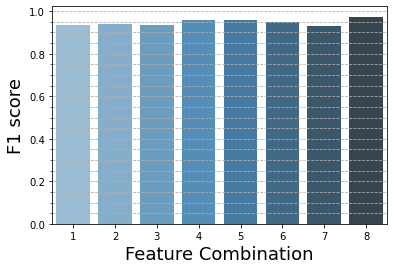

In [17]:
# bar plot of f1 scores

fig = sns.barplot(x=np.arange(1,9), y=f1_scores,palette="Blues_d")
    
plt.xlabel('Feature Combination',fontsize = 18)
plt.ylabel('F1 score',fontsize = 18)
plt.title("")
ticks = np.arange(0, 1, 0.05)
fig.set_yticks(ticks, minor=True)
fig.grid(which='both',axis='y',linestyle='dashed')
plt.rc('axes', axisbelow=True)
plt.savefig('saved_figures_2/f1_scores_RF.pdf', format = 'pdf', dpi = 1200)
#plt.close()

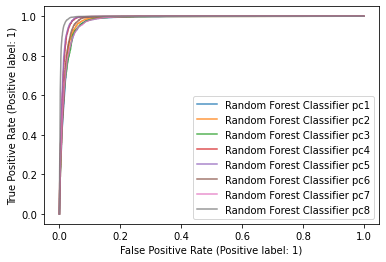

In [18]:
# plot of ROC curves

ax = plt.gca()
n = 0
for i in ROC_curves:
    n += 1
    i.plot(ax=ax, alpha=0.8, label = 'Random Forest Classifier '+ 'pc'+ str(n))
plt.savefig('saved_figures_2/ROC_curve_feature_combinations_RF.png')   

In [19]:
cv_scores_RF = pd.DataFrame(CV_scores)
cv_scores_RF.to_excel('RF_CV_scores_training2.xlsx')

In [20]:
f1_scores_RF = pd.DataFrame(f1_scores)
f1_scores_RF.to_excel('RF_F1_scores2.xlsx')

In [21]:
accuracy_scores_RF = pd.DataFrame(accuracy_scores)
accuracy_scores_RF.to_excel('RF_accuracy_scores2.xlsx')

In [22]:
precision_scores_RF = pd.DataFrame(precision_scores)
precision_scores_RF.to_excel('RF_precision_scores2.xlsx')

In [23]:
recall_scores_RF = pd.DataFrame(recall_scores)
recall_scores_RF.to_excel('RF_recall_scores2.xlsx')

In [24]:
R2_scores_RF = pd.DataFrame(R2_scores)
R2_scores_RF.to_excel('RF_R2_scores2.xlsx')

In [ ]:
roc_auc_scores = pd.DataFrame(roc_auc_scores)
roc_auc_scores.to_excel('RF_roc_auc_scores.xlsx')

## Prediction results

In [10]:
validation_y = pd.read_excel('ML_validation_target.xlsx')
df_coor = validation_y[['POINT_X', 'POINT_Y']]

In [11]:
# extracting the values that are probability for rockfall, class 1

df_coor['RF_prob_p1'] = pred_release_prob_RF[0][:,1]
df_coor['RF_prob_p2'] = pred_release_prob_RF[1][:,1]
df_coor['RF_prob_p3'] = pred_release_prob_RF[2][:,1]
df_coor['RF_prob_p4'] = pred_release_prob_RF[3][:,1]
df_coor['RF_prob_p5'] = pred_release_prob_RF[4][:,1]
df_coor['RF_prob_p6'] = pred_release_prob_RF[5][:,1]
df_coor['RF_prob_p7'] = pred_release_prob_RF[6][:,1]
df_coor['RF_prob_p8'] = pred_release_prob_RF[7][:,1]

<ipython-input-11-19d60ae8ace2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coor['RF_prob_p1'] = pred_release_prob_RF[0][:,1]


In [12]:
df_coor['RF_prediction_p1'] = pred_release_testing_RF[0]
df_coor['RF_prediction_p2'] = pred_release_testing_RF[1]
df_coor['RF_prediction_p3'] = pred_release_testing_RF[2]
df_coor['RF_prediction_p4'] = pred_release_testing_RF[3]
df_coor['RF_prediction_p5'] = pred_release_testing_RF[4]
df_coor['RF_prediction_p6'] = pred_release_testing_RF[5]
df_coor['RF_prediction_p7'] = pred_release_testing_RF[6]
df_coor['RF_prediction_p8'] = pred_release_testing_RF[7]

In [ ]:
#df_coor.to_excel('prediction_results_validation_RF2.xlsx')

In [ ]:
#df_coor = pd.read_excel('prediction_results_validation_RF2.xlsx')

In [13]:
df_coor = df_coor[['POINT_X', 'POINT_Y', 'RF_prob_p1',
       'RF_prob_p2', 'RF_prob_p3', 'RF_prob_p4', 'RF_prob_p5', 'RF_prob_p6',
       'RF_prob_p7', 'RF_prob_p8', 'RF_prediction_p1', 'RF_prediction_p2',
       'RF_prediction_p3', 'RF_prediction_p4', 'RF_prediction_p5',
       'RF_prediction_p6', 'RF_prediction_p7', 'RF_prediction_p8']].copy()

In [14]:
df_coor['ReleaseArea'] = validation_y['ReleaseArea'] 

In [15]:
result1 = []
for row in range(0,len(df_coor)):
    if df_coor['ReleaseArea'].iloc[row] == 1 and df_coor['RF_prediction_p1'].iloc[row] == 1:
        result1.append('TP')
    elif df_coor['ReleaseArea'].iloc[row] == 0 and df_coor['RF_prediction_p1'].iloc[row] == 0:
        result1.append('TN')
    elif df_coor['RF_prediction_p1'].iloc[row] == 1 and df_coor['ReleaseArea'].iloc[row] == 0:
        result1.append('FP')
    elif df_coor['RF_prediction_p1'].iloc[row] == 0 and df_coor['ReleaseArea'].iloc[row] == 1:
        result1.append('FN')
    else:
        print('NaN')
        
        
df_coor['result_p1'] = result1

In [16]:
result2 = []
for row in range(0,len(df_coor)):
    if df_coor['ReleaseArea'].iloc[row] == 1 and df_coor['RF_prediction_p2'].iloc[row] == 1:
        result2.append('TP')
    elif df_coor['ReleaseArea'].iloc[row] == 0 and df_coor['RF_prediction_p2'].iloc[row] == 0:
        result2.append('TN')
    elif df_coor['RF_prediction_p2'].iloc[row] == 1 and df_coor['ReleaseArea'].iloc[row] == 0:
        result2.append('FP')
    elif df_coor['RF_prediction_p2'].iloc[row] == 0 and df_coor['ReleaseArea'].iloc[row] == 1:
        result2.append('FN')
    else:
        print('NaN')
df_coor['result_p2'] = result2

IndentationError: expected an indented block (<ipython-input-16-48e7646046fa>, line 13)

In [ ]:
result3 = []
for row in range(0,len(df_coor)):
    if df_coor['ReleaseArea'].iloc[row] == 1 and df_coor['RF_prediction_p3'].iloc[row] == 1:
        result3.append('TP')
    elif df_coor['ReleaseArea'].iloc[row] == 0 and df_coor['RF_prediction_p3'].iloc[row] == 0:
        result3.append('TN')
    elif df_coor['RF_prediction_p3'].iloc[row] == 1 and df_coor['ReleaseArea'].iloc[row] == 0:
        result3.append('FP')
    elif df_coor['RF_prediction_p3'].iloc[row] == 0 and df_coor['ReleaseArea'].iloc[row] == 1:
        result3.append('FN')
    else:
        print('NaN')
        
        
df_coor['result_p3'] = result3

In [17]:
result4 = []
for row in range(0,len(df_coor)):
    if df_coor['ReleaseArea'].iloc[row] == 1 and df_coor['RF_prediction_p4'].iloc[row] == 1:
        result4.append('TP')
    elif df_coor['ReleaseArea'].iloc[row] == 0 and df_coor['RF_prediction_p4'].iloc[row] == 0:
        result4.append('TN')
    elif df_coor['RF_prediction_p4'].iloc[row] == 1 and df_coor['ReleaseArea'].iloc[row] == 0:
        result4.append('FP')
    elif df_coor['RF_prediction_p4'].iloc[row] == 0 and df_coor['ReleaseArea'].iloc[row] == 1:
        result4.append('FN')
    else:
        print('NaN')
        
        
df_coor['result_p4'] = result4

In [40]:
result5 = []
for row in range(0,len(df_coor)):
    if df_coor['ReleaseArea'].iloc[row] == 1 and df_coor['RF_prediction_p5'].iloc[row] == 1:
        result5.append('TP')
    elif df_coor['ReleaseArea'].iloc[row] == 0 and df_coor['RF_prediction_p5'].iloc[row] == 0:
        result5.append('TN')
    elif df_coor['RF_prediction_p5'].iloc[row] == 1 and df_coor['ReleaseArea'].iloc[row] == 0:
        result5.append('FP')
    elif df_coor['RF_prediction_p5'].iloc[row] == 0 and df_coor['ReleaseArea'].iloc[row] == 1:
        result5.append('FN')
    else:
        print('NaN')
        
        
df_coor['result_p5'] = result5

In [41]:
result6 = []
for row in range(0,len(df_coor)):
    if df_coor['ReleaseArea'].iloc[row] == 1 and df_coor['RF_prediction_p6'].iloc[row] == 1:
        result6.append('TP')
    elif df_coor['ReleaseArea'].iloc[row] == 0 and df_coor['RF_prediction_p6'].iloc[row] == 0:
        result6.append('TN')
    elif df_coor['RF_prediction_p6'].iloc[row] == 1 and df_coor['ReleaseArea'].iloc[row] == 0:
        result6.append('FP')
    elif df_coor['RF_prediction_p6'].iloc[row] == 0 and df_coor['ReleaseArea'].iloc[row] == 1:
        result6.append('FN')
    else:
        print('NaN')
        
        
df_coor['result_p6'] = result6

In [42]:
result7 = []
for row in range(0,len(df_coor)):
    if df_coor['ReleaseArea'].iloc[row] == 1 and df_coor['RF_prediction_p7'].iloc[row] == 1:
        result7.append('TP')
    elif df_coor['ReleaseArea'].iloc[row] == 0 and df_coor['RF_prediction_p7'].iloc[row] == 0:
        result7.append('TN')
    elif df_coor['RF_prediction_p7'].iloc[row] == 1 and df_coor['ReleaseArea'].iloc[row] == 0:
        result7.append('FP')
    elif df_coor['RF_prediction_p7'].iloc[row] == 0 and df_coor['ReleaseArea'].iloc[row] == 1:
        result7.append('FN')
    else:
        print('NaN')
        
        
df_coor['result_p7'] = result7

In [43]:
result8 = []
for row in range(0,len(df_coor)):
    if df_coor['ReleaseArea'].iloc[row] == 1 and df_coor['RF_prediction_p8'].iloc[row] == 1:
        result8.append('TP')
    elif df_coor['ReleaseArea'].iloc[row] == 0 and df_coor['RF_prediction_p8'].iloc[row] == 0:
        result8.append('TN')
    elif df_coor['RF_prediction_p8'].iloc[row] == 1 and df_coor['ReleaseArea'].iloc[row] == 0:
        result8.append('FP')
    elif df_coor['RF_prediction_p8'].iloc[row] == 0 and df_coor['ReleaseArea'].iloc[row] == 1:
        result8.append('FN')
    else:
        print('NaN')
        
        
df_coor['result_p8'] = result8

In [44]:
df_coor.to_excel('prediction_results_validation_RF2.xlsx')